# Short-term Temperature Model Test

## Import dependencies and data

In [40]:
# import dependencies
import os
import json
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [41]:
# define relevant paths
home_path = os.path.dirname(os.getcwd())
data_path = home_path + '\\data\\'
plot_path = home_path + '\\plotting\\plots\\'
save_path = home_path + '\\model\\saved\\'

In [42]:
# get merged data
data = pd.read_csv(
    data_path + 'data_merged.csv',
    header=[0, 1],
    index_col=[0, 1, 2, 3, 4]
)

# convert index.date col to datetime
#data.index = pd.to_datetime(data.index.values)
data.loc[:, ('time', 'date')] = pd.to_datetime(data.time.date)

In [43]:
# define X vars
x_vars = [
    ('flow', 'TA01_GP101'),
    ('state', 'TA01_output'),
    ('state', 'TA02_output'),
    ('temperatures', 'DC_GT101_GM101'),
    ('temperatures', 'DC_GT102_GM102'),
    ('temperatures', 'DC_GT103_GM103'),
    ('temperatures', 'DC_GT104_GM104'),
    ('temperatures', 'DC_GT401_GM401'),
    ('temperatures', 'TA01_GT401_GM401'),
    ('temperatures', 'TA02_GT401_GM401'),
    ('temperatures', 'DC_GT301_damped'),
    ('temperatures', 'DC_GT301_outdoor'),
    ('humidity', 'DC_GT101_GM101'),
    ('humidity', 'DC_GT102_GM102'),
    ('humidity', 'DC_GT103_GM103'),
    ('humidity', 'DC_GT104_GM104'),
    ('humidity', 'DC_GT401_GM401'),
    ('setpoints', 'TA01_GT10X_GM10X'),
    ('sun', 'gsi'),
    ('sun', 'gsi_deriv'),
    ('sun', 'vol'),
    ('sun', 'vol_deriv'),
    ('wind', 'Wx'),
    ('wind', 'Wy'),
    ('time', 'dayofyear'),
    ('time', 'monthofyear'),
    ('time', 'minofday'),
    ('time', 'minofday_deriv'),
    ('time', 'hourofday')
]

# filter columns to keep only x_vars
data = data[x_vars].copy()

## Describe Df

In [44]:
# print number of NAs
print('Number of NAs\n')
print(data.isna().sum())
print('\n\n')

Number of NAs

category      sensor_ID       
flow          TA01_GP101          13
state         TA01_output         15
              TA02_output         14
temperatures  DC_GT101_GM101      12
              DC_GT102_GM102      12
              DC_GT103_GM103      11
              DC_GT104_GM104      11
              DC_GT401_GM401      13
              TA01_GT401_GM401    13
              TA02_GT401_GM401    12
              DC_GT301_damped     12
              DC_GT301_outdoor    12
humidity      DC_GT101_GM101      12
              DC_GT102_GM102      12
              DC_GT103_GM103      12
              DC_GT104_GM104      10
              DC_GT401_GM401      14
setpoints     TA01_GT10X_GM10X    14
sun           gsi                  2
              gsi_deriv            2
              vol                  2
              vol_deriv            2
wind          Wx                   2
              Wy                   2
time          dayofyear            2
              monthofyear    

In [45]:
# remove single NAN
data = data.dropna(how='any')

In [46]:
# # reduce to one OBS per MIN
# data = data.groupby(['month', 'day', 'hour', 'minute'], sort=False).mean()
# dataMean = data.groupby(['month', 'day', 'hour', 'minute'], sort=False).mean()
# dataFirst = data.groupby(['month', 'day', 'hour', 'minute'], sort=False).first()
# dataLast = data.groupby(['month', 'day', 'hour', 'minute'], sort=False).last()

## GH Temperature & Humidity

In [47]:
### create "better" estimate of temperature var, w. proper avg.
data[('temperatures', 'TA01_GT10X_GM10X')] = data.temperatures[[
    # ('DC_GT102_GM101'),
    ('DC_GT102_GM102'), 
    ('DC_GT103_GM103'), 
    ('DC_GT104_GM104')
]].values.mean(axis=1)

In [48]:
### create "better" estimate of temperature var, w. proper avg.
data[('humidity', 'TA01_GT10X_GM10X')] = data.humidity[[
    # ('DC_GT102_GM101'),
    ('DC_GT102_GM102'), 
    ('DC_GT103_GM103'), 
    ('DC_GT104_GM104')
]].values.mean(axis=1)

## Kalman filtering

In [49]:
cols = [
    (('temperatures', 'TA01_GT10X_GM10X'), 3),
#     (('temperatures', 'DC_GT401_GM401'), 2),
#     (('temperatures', 'TA01_GT401_GM401'), 2),
#     (('temperatures', 'DC_GT301_damped'), 4),
    (('humidity', 'TA01_GT10X_GM10X'), 3),
    
]

for colSpec in cols:
    for day in data.groupby(['month', 'day']).count().index.values:
        # apply KALMAN filter to measurements
        col = colSpec[0]
        varExp = colSpec[-1]

        # get data
        X = data.loc[day, col].values
        n = len(X)

        # process variance, measurement variance
        Q = 1e-5
        R = 0.1**varExp

        xhat=np.zeros(n)      # a posteri estimate of x
        P=np.zeros(n)         # a posteri error estimate
        xhatminus=np.zeros(n) # a priori estimate of x
        Pminus=np.zeros(n)    # a priori error estimate
        K=np.zeros(n)         # gain or blending factor

        # intial guesses
        xhat[0] = X[0]
        P[0] = 1

        for k in range(1,n):
            # time update
            xhatminus[k] = xhat[k-1]
            Pminus[k] = P[k-1]+Q

            # measurement update
            K[k] = Pminus[k]/( Pminus[k]+R )
            xhat[k] = xhatminus[k]+K[k]*(X[k]-xhatminus[k])
            P[k] = (1-K[k])*Pminus[k]

        data.loc[day, col] = xhat

C:\Users\Oskar\AppData\Local\Temp\ipykernel_24716\1767311629.py:17: PerformanceWarning: indexing past lexsort depth may impact performance.
  X = data.loc[day, col].values
C:\Users\Oskar\AppData\Local\Temp\ipykernel_24716\1767311629.py:44: PerformanceWarning: indexing past lexsort depth may impact performance.
  data.loc[day, col] = xhat


## Feature Engineering

In [50]:
# create flow scaling from 1.0 -> MAX
data[('flow', 'TA01_scaled')] = data.flow.TA01_GP101 / data.flow.TA01_GP101.min()
data[('flow', 'TA02_scaled')] = data.state.TA02_output / 100

# scale TA01 inflow temperature (amplified and 0-based)
data[('temperatures', 'TA01_GT401_GM401_scaled1')] = data.temperatures.TA01_GT401_GM401 * data.flow.TA01_scaled
data[('temperatures', 'TA01_GT401_GM401_scaled2')] = data.temperatures.TA01_GT401_GM401 * (data.flow.TA01_scaled - 1)

# scale TA02 inflow temperature, i.e. outdoors temp (0-based)
data[('temperatures', 'TA02_GT401_GM401_scaled')] = data.temperatures.DC_GT301_damped * data.flow.TA02_scaled

In [51]:
t_steps = 20
n_steps = t_steps

# data[('temperatures', 'TA01_GT10X_GM10X_first')] = data[('temperatures', 'TA01_GT10X_GM10X')].rolling(n_steps).apply(lambda vec: vec[0], raw=True)
#data[('temperatures', 'TA01_GT10X_GM10X_diff')] = data[('temperatures', 'TA01_GT10X_GM10X')].rolling(n_steps).apply(lambda vec: vec[n_steps-t_steps] - vec[0], raw=True)
data[('flow', 'TA01_scaled_mean')] = data[('flow', 'TA01_scaled')].rolling(n_steps).mean()
data[('flow', 'TA02_scaled_mean')] = data[('flow', 'TA01_scaled')].rolling(n_steps).mean()
data[('flow', 'TA01_scaled_max')] = data[('flow', 'TA01_scaled')].rolling(n_steps).max()
data[('flow', 'TA02_scaled_max')] = data[('flow', 'TA01_scaled')].rolling(n_steps).max()
data[('temperatures', 'TA01_GT401_GM401_scaled1_mean')] = data[('temperatures', 'TA01_GT401_GM401_scaled1')].rolling(n_steps).mean()
data[('temperatures', 'TA01_GT401_GM401_scaled1_max')] = data[('temperatures', 'TA01_GT401_GM401_scaled1')].rolling(n_steps).max()
data[('temperatures', 'TA01_GT401_GM401_scaled2_mean')] = data[('temperatures', 'TA01_GT401_GM401_scaled2')].rolling(n_steps).mean()
data[('temperatures', 'TA01_GT401_GM401_scaled2_max')] = data[('temperatures', 'TA01_GT401_GM401_scaled2')].rolling(n_steps).max()
data[('temperatures', 'TA02_GT401_GM401_scaled_mean')] = data[('temperatures', 'TA02_GT401_GM401_scaled')].rolling(n_steps).mean()
data[('temperatures', 'DC_GT301_damped_mean')] = data[('temperatures', 'DC_GT301_damped')].rolling(n_steps).mean()
data[('temperatures', 'DC_GT301_damped_min')] = data[('temperatures', 'DC_GT301_damped')].rolling(n_steps).min()
data[('humidity', 'TA01_GT10X_GM10X_mean')] = data[('humidity', 'TA01_GT10X_GM10X')].rolling(n_steps).mean()
data[('humidity', 'TA01_GT10X_GM10X_max')] = data[('humidity', 'TA01_GT10X_GM10X')].rolling(n_steps).max()
data[('sun', 'gsi_mean')] = data[('sun', 'gsi')].rolling(n_steps).mean()
data[('sun', 'gsi_max')] = data[('sun', 'gsi')].rolling(n_steps).max()
data[('sun', 'gsi_deriv_mean')] = data[('sun', 'gsi_deriv')].rolling(n_steps).mean()
data[('sun', 'gsi_deriv_max')] = data[('sun', 'gsi_deriv')].rolling(n_steps).max()
data[('wind', 'Wx_mean')] = data[('wind', 'Wx')].rolling(n_steps).mean()
data[('wind', 'Wy_mean')] = data[('wind', 'Wy')].rolling(n_steps).mean()
data[('time', 'minofday')] = data[('time', 'minofday')].rolling(n_steps).apply(lambda vec: vec[0], raw=True)
data[('time', 'minofday_deriv')] = data[('time', 'minofday_deriv')].rolling(n_steps).apply(lambda vec: vec[0], raw=True)

In [52]:
targets = data.pop(('temperatures', 'TA01_GT10X_GM10X'))
# targets = (targets - targets.shift(t_steps))

## Split into training / testing

In [55]:
# filter data by variables
model_vars = [
#     ('temperatures', 'TA01_GT10X_GM10X_first'),
    ('flow', 'TA01_scaled_mean'),
    ('flow', 'TA02_scaled_mean'),
    ('flow', 'TA01_scaled_max'),
    ('flow', 'TA02_scaled_max'),
    ('temperatures', 'TA01_GT401_GM401_scaled1_mean'),
    ('temperatures', 'TA01_GT401_GM401_scaled1_max'),
    ('temperatures', 'TA01_GT401_GM401_scaled2_mean'),
    ('temperatures', 'TA01_GT401_GM401_scaled2_max'),
    ('temperatures', 'TA02_GT401_GM401_scaled_mean'),
    ('temperatures', 'DC_GT301_damped_mean'),
    ('temperatures', 'DC_GT301_damped_min'),
    ('humidity', 'TA01_GT10X_GM10X_mean'),
    ('humidity', 'TA01_GT10X_GM10X_max'),
    ('sun', 'gsi_mean'),
    ('sun', 'gsi_max'),
    ('sun', 'gsi_deriv_mean'),
    ('sun', 'gsi_deriv_max'),
    ('wind', 'Wx_mean'),
    ('wind', 'Wy_mean'),
    ('time', 'minofday'),
    ('time', 'minofday_deriv')
]

data = data[model_vars].copy()

In [56]:
data = data.iloc[n_steps:]
targets = targets.iloc[n_steps:]

In [57]:
## Randomly select days for trainin and testing
days = data.groupby(['month', 'day']).count().index.values

# get number of days f. testing / training
train_frac = 0.9
train_n = int(len(days) * train_frac)
test_n = len(days) - train_n

# split dataset
np.random.shuffle(days)
mask = np.array([day in list(days[:train_n]) for day in data.index.droplevel(-1).droplevel(-1).droplevel(-1).values])
data_train = data.loc[mask].copy()
data_test = data.loc[~mask].copy()

targets_train = targets.loc[mask].copy()
targets_test = targets.loc[~mask].copy()

del data, targets

## Normalize w. training data

In [58]:
col_params = {}
for col in data_train.columns[1:]:
# for col in data_train.columns:
    
    mean = data_train[col].mean()
    std = data_train[col].std()
    max_val = data_train[col].max()
    min_val = data_train[col].min()
    
#     data_train[col] = (data_train[col] - mean) / std
#     data_test[col] = (data_test[col] - mean) / std    
    
# #     # make positive
    data_train[col] = data_train[col] + abs(min(0, min_val))
    data_train[col] = (data_train[col] - min_val) / (max_val - min_val)
    
    data_test[col] = data_test[col] + abs(min(0, min_val))
    data_test[col] = (data_test[col] - min_val) / (max_val - min_val)
    data_test[col] = data_test[col].apply(lambda val: max(min(val, 1.0), 0.0))
    
    col_params[col] = {
        'mean':mean,
        'std':std,
        'max':max_val,
        'min':min_val
    }

## Save data info

In [59]:
# days = {
#     'training':days[:train_n],
#     'testing':days[train_n:]
# }

In [60]:
# json_path = home_path + '\\misc\\data_split.json'
# json_obj = json.dumps(days)
# with open(json_path, 'w', encoding='utf-8') as f:
#     json.dump(json_obj, f, ensure_ascii=False, indent=4)

In [61]:
# json DUMP params....

## Data preparation

### Flag datapoints

In [62]:
def date_flagger(data, n_steps):
    # get flagged datesvalues
#     data['minute'] = data.index.get_level_values(3).values    
#     data['date_flag'] = data.minute - data.minute.shift(n_steps) != (n_steps)

    data['hour'] = data.index.get_level_values(2).values    
    data['date_flag'] = data.hour - data.hour.shift(n_steps) > 1
    
    # get positions in data, w.r.t. n_step removed observations at start
    flagged_idx = np.where(data.date_flag.values == 1)
    flagged_idx = flagged_idx[0] - n_steps
    
    del data['hour'], data['date_flag']
    
    return flagged_idx

In [63]:
# get flags
flags_train = date_flagger(data_train, n_steps=n_steps)
flags_test = date_flagger(data_test, n_steps=n_steps)

idxs_train = [idx not in flags_train for idx in range(len(data_train))]
idxs_test = [idx not in flags_test for idx in range(len(data_test))]

In [64]:
data_train = data_train.values[idxs_train]
data_test = data_test.values[idxs_test]

targets_train = targets_train.values[idxs_train]
targets_test = targets_test.values[idxs_test]

## Define XGBOOST

In [65]:
import xgboost as xgb

model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=2000,
    max_depth=5,
    #learning_rate=0.1
)

In [66]:
model.fit(data_train, targets_train, verbose=True)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=5000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [67]:
preds = model.predict(data_test)

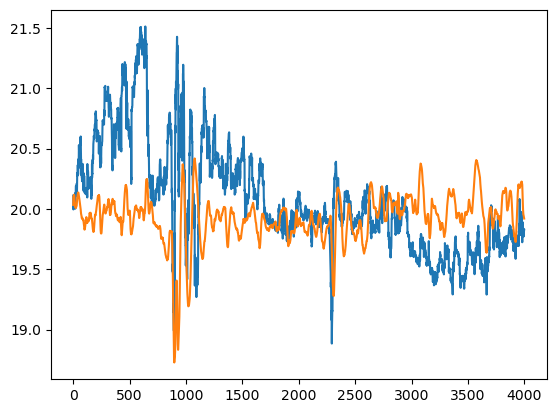

In [69]:
plt.plot(preds[:4000])
plt.plot(targets_test[:4000])